In [153]:
import os
import datetime

import pandas as pd
import geopandas as gpd
import shapely

import pyrosm
import r5py
import gtfs_kit as gk

from common_functions import setup_folders, download_transitland_feeds_for_area, download_topography, scatter_plot, set_modules_to_autoreload

set_modules_to_autoreload()

parent_folder = "R6_analysis"
setup_folders(parent_folder, ['osm', 'gtfs-pre', 'gtfs-post', 'topography'])

travel_date_pre = "2023-11-21"
travel_date_post = "2024-01-10"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#download osm data using pyrosm and save to vancouver-travel-times/osm/

osm = pyrosm.get_data("Vancouver", directory=f"{parent_folder}/osm/")

Downloaded Protobuf data 'Vancouver.osm.pbf' (56.57 MB) to:
'c:\Users\marki\Github\osm-sketches\R6_analysis\osm\Vancouver.osm.pbf'


In [3]:
# Initialize the OSM object 
osm = pyrosm.OSM(parent_folder + "/osm/Vancouver.osm.pbf")

Centroid: [-122.88546194281031, 49.16939319961179]
Estimated UTM CRS: EPSG:32610
Number of points in x direction: 16
Number of points in y direction: 20
Generated 320 grid points.
Centroid: [np.float64(-122.88541219002698), np.float64(49.1693800720825)]
Estimated UTM CRS: EPSG:32610
                         geometry
0   POINT (504349.164 5441280.93)
1  POINT (512349.128 5451305.131)
Aspect ratio (height/width): 1.2530309123474503


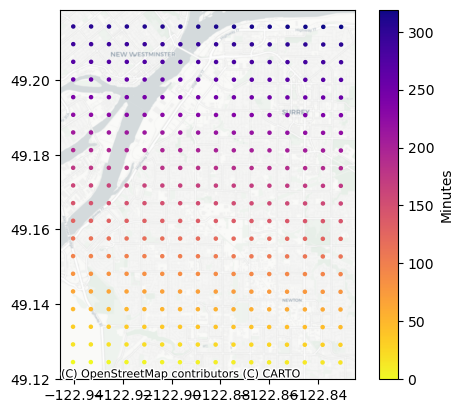

In [140]:
#get the bounding box of the osm data
#bbox = drive_net.total_bounds  # minx, miny, maxx, maxy
#print("OSM data bounding box:", bbox)

#p1, p2 = (bbox[0], bbox[1]), (bbox[2], bbox[3])

p1, p2 = (49.212297892509305, -122.937467355485)[::-1], (49.12648850671428, -122.83345653013562)[::-1]

from common_functions import generate_points_on_land
grid_points, land = generate_points_on_land(p1, p2, spacing=500)

scatter_plot(grid_points.geometry.x, grid_points.geometry.y, grid_points.id)

In [135]:
for sub_folder, travel_date in [(parent_folder + "/gtfs-pre/", travel_date_pre), (parent_folder + "/gtfs-post/", travel_date_post)]:

    download_transitland_feeds_for_area(p1, p2, travel_date, sub_folder)
    gtfs_paths = [sub_folder + name for name in os.listdir(sub_folder) if name.endswith(".zip")
                ]
    #Some trips have arrival or departure times > 72:00:00 hours which r5py cannot handle. Find these trips and remove them from the feed, re-saving the feed to a .zip file

    for path in gtfs_paths:
        feed = gk.read_feed(path, dist_units="km")

        #check if any stop_times have arrival or departure times higher than 72:00:00 hours
        max_seconds = 72 * 3600
        feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time).dt.total_seconds()
        feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time).dt.total_seconds()

        offending_trips = feed.stop_times[(feed.stop_times.departure_time > max_seconds) | (feed.stop_times.arrival_time > max_seconds)].trip_id.unique()

        if len(offending_trips) == 0:
            print("{} trips in feed {} have arrival/departure times > 72 hours. No pruning needed.".format(len(offending_trips), path))
            continue

        print("{} trips in feed {} have arrival/departure times > 72 hours. Pruning trips.".format(len(offending_trips), path))
        #delete offending trips from feed
        feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(offending_trips)]

        #convert back to hh:mm:ss format. Format as string
        feed.stop_times.departure_time = pd.to_timedelta(feed.stop_times.departure_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
        feed.stop_times.arrival_time = pd.to_timedelta(feed.stop_times.arrival_time, unit='s').apply(lambda x: str(x).split(' ')[-1])
        #save modified feed back to zip file
        feed.to_file(path)
    

4 unique feeds found in area.
Checking archive for f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle
Download feed for agency f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle. Date range: 2023-10-29 00:00:00 to 2024-10-28 00:00:00
Checking archive for f-9-flixbus
Download feed for agency f-9-flixbus. Date range: 2023-10-22 00:00:00 to 2025-01-16 00:00:00
Checking archive for f-c28-nstranslinkca
Download feed for agency f-c28-nstranslinkca. Date range: 2023-09-04 00:00:00 to 2023-12-31 00:00:00
Checking archive for f-rider~express~ca
No feed versions found for f-rider~express~ca before 2023-10-30, skipping.
5 trips in feed R6_analysis/gtfs-pre/2023-10-30_f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle.zip have arrival/departure times > 72 hours. Pruning trips.
0 trips in feed R6_analysis/gtfs-pre/2023-10-30_f-9-flixbus.zip have arrival/departure times > 72 hours. No pruning needed.
0 trips in feed R6_analysis/gtfs-pre/2023-10-30_f-c28-nstranslinkca.zip have arrival/departure times

In [136]:
#additional data cleaning for GTFS
for sub_folder, travel_date in [(parent_folder + "/gtfs-pre/", travel_date_pre), (parent_folder + "/gtfs-post/", travel_date_post)]:
    gtfs_paths = [sub_folder + name for name in os.listdir(sub_folder) if name.endswith(".zip")
                ]
    #check for shapes with only one point. Remove them, and find trips that use those shapes and remove them too
    for path in gtfs_paths:
        feed = gk.read_feed(path, dist_units="km")

        shape_lengths = feed.shapes.groupby('shape_id').size()
        single_point_shapes = shape_lengths[shape_lengths == 1].index.tolist()

        if len(single_point_shapes) == 0:
            print("No single-point shapes found in feed {}".format(path))
            continue

        print("Found {} single-point shapes in feed {}. Pruning shapes and associated trips.".format(len(single_point_shapes), path))
        print("Single-point shape IDs:", single_point_shapes)
        print("Affected trip IDs:", feed.trips[feed.trips.shape_id.isin(single_point_shapes)].trip_id.unique().tolist())

        #remove single-point shapes
        feed.shapes = feed.shapes[~feed.shapes.shape_id.isin(single_point_shapes)]
        #remove trips that use those shapes
        feed.trips = feed.trips[~feed.trips.shape_id.isin(single_point_shapes)]
        #remove stop_times for those trips
        feed.stop_times = feed.stop_times[~feed.stop_times.trip_id.isin(feed.trips[feed.trips.shape_id.isin(single_point_shapes)].trip_id.unique())]

        #save modified feed back to zip file
        feed.to_file(path)


No single-point shapes found in feed R6_analysis/gtfs-pre/2023-10-30_f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle.zip
No single-point shapes found in feed R6_analysis/gtfs-pre/2023-10-30_f-9-flixbus.zip
No single-point shapes found in feed R6_analysis/gtfs-pre/2023-10-30_f-c28-nstranslinkca.zip
No single-point shapes found in feed R6_analysis/gtfs-post/2024-01-10_f-9-amtrak~amtrakcalifornia~amtrakcharteredvehicle.zip
No single-point shapes found in feed R6_analysis/gtfs-post/2024-01-10_f-9-flixbus.zip
Found 1 single-point shapes in feed R6_analysis/gtfs-post/2024-01-10_f-c28-nstranslinkca.zip. Pruning shapes and associated trips.
Single-point shape IDs: ['4484']
Affected trip IDs: ['48441']


In [8]:
download_topography(p1, p2, parent_folder)

Topography data downloaded successfully.


In [154]:

gtfs_paths_pre = [parent_folder + "/gtfs-pre/" + name for name in os.listdir(parent_folder + "/gtfs-pre/") if name.endswith(".zip")]

gtfs_paths_post = [parent_folder + "/gtfs-post/" + name for name in os.listdir(parent_folder + "/gtfs-post/") if name.endswith(".zip")]

gtfs_paths_pre

transport_network_pre = r5py.TransportNetwork(
    osm_pbf = parent_folder + "/osm/Vancouver.osm.pbf",
    gtfs = gtfs_paths_pre,
    elevation_model = parent_folder + "/topography/topography-wgs.tif"
)

transport_network_post = r5py.TransportNetwork(
    osm_pbf = parent_folder + "/osm/Vancouver.osm.pbf",
    gtfs = gtfs_paths_post,
    elevation_model = parent_folder + "/topography/topography-wgs.tif"
)

In [ ]:
origins = grid_points.copy().reset_index(drop=True)
origins.geometry = origins.geometry.centroid

destinations = gpd.GeoDataFrame(
    {
        "id": ["scott rd"],
        "geometry": [shapely.Point((49.20443123414976, -122.87251867320981)[::-1])],
    },
    crs="EPSG:4326",
)

transit_travel_times_pre = r5py.TravelTimeMatrix(
    transport_network_pre,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime("2024-11-04 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.TRANSIT,
        r5py.TransportMode.WALK
    ],
    snap_to_network=True,
)

C:\Users\marki\AppData\Local\Temp\ipykernel_45568\816226453.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.geometry = origins.geometry.centroid


In [ ]:

transit_travel_times_post = r5py.TravelTimeMatrix(
    transport_network_post,
    origins=origins,
    destinations=destinations,
    departure=datetime.datetime.strptime("2024-02-05 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[
        r5py.TransportMode.TRANSIT,
        r5py.TransportMode.WALK
    ],
    snap_to_network=True,
)

In [170]:
detailed_itineraries_pre = r5py.DetailedItineraries(
    transport_network_pre,
    origins=origins[origins.id == 30],
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date_pre + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[r5py.TransportMode.TRANSIT, r5py.TransportMode.WALK],
    snap_to_network=True,
)

detailed_itineraries_post = r5py.DetailedItineraries(
    transport_network_post,
    origins=origins[origins.id == 40],
    destinations=destinations,
    departure=datetime.datetime.strptime(travel_date_post + " 07:30", "%Y-%m-%d %H:%M"),
    transport_modes=[r5py.TransportMode.TRANSIT, r5py.TransportMode.WALK],
    snap_to_network=True,
)

pre_feed = gk.read_feed(gtfs_paths_pre[2], dist_units="km")
post_feed = gk.read_feed(gtfs_paths_post[2], dist_units="km")

detailed_itineraries_pre = detailed_itineraries_pre.merge(pre_feed.routes[['route_id', 'route_short_name', 'route_long_name']], on='route_id', how='left')
detailed_itineraries_post = detailed_itineraries_post.merge(post_feed.routes[['route_id', 'route_short_name', 'route_long_name']], on='route_id', how='left')

print(detailed_itineraries_pre.route_short_name.unique())
print(detailed_itineraries_post.route_short_name.unique())

<StringArray>
[<NA>, '321', 'R1', '324', '394']
Length: 5, dtype: string
<StringArray>
[<NA>, '319', 'R6', '640']
Length: 4, dtype: string


In [187]:
import gtfs_segments

segments = gtfs_segments.get_gtfs_segments(gtfs_paths_post[2])

Using the busiest day: 2024-01-12


c:\Users\marki\anaconda3\envs\geo\lib\site-packages\gtfs_segments\partridge_func.py:85: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_frame.fillna(False, inplace=True)


Excluding Trip: 13723215 because of failed snap!
Excluding Trip: 13723326 because of failed snap!
Excluding Trip: 13723569 because of failed snap!
Total trips processed:  29194
Total defective trips:  114
Percentage defective trips: 0.39%


<Axes: >

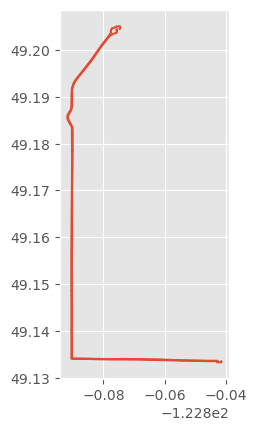

In [189]:
#get segments for R6
trips = post_feed.trips
routes = post_feed.routes

trips = trips.merge(routes[['route_id', 'route_short_name']], on='route_id', how='left')

r6_route_id = routes[routes.route_short_name == 'R6'].route_id.unique()[0]

r6_segments = segments[segments.route_id == r6_route_id]

r6_segments.plot()

Centroid: [np.float64(-122.88541219002698), np.float64(49.1693800720825)]
Estimated UTM CRS: EPSG:32610
                         geometry
0   POINT (504349.164 5441280.93)
1  POINT (512349.128 5451305.131)
Aspect ratio (height/width): 1.2530309123474503


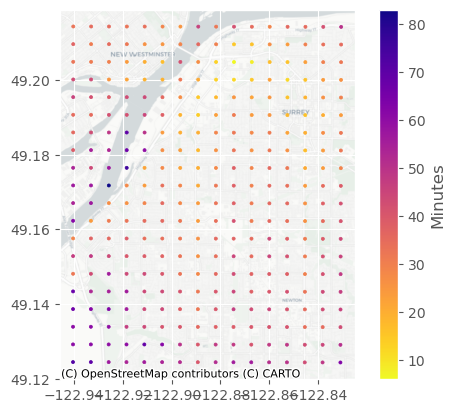

Centroid: [np.float64(-122.88541219002698), np.float64(49.1693800720825)]
Estimated UTM CRS: EPSG:32610
                         geometry
0   POINT (504349.164 5441280.93)
1  POINT (512349.128 5451305.131)
Aspect ratio (height/width): 1.2530309123474503
X limits: (np.float64(-122.94011438181903), np.float64(-122.83070999823495))
Y limits: (np.float64(49.124574721323064), np.float64(49.21418542284193))


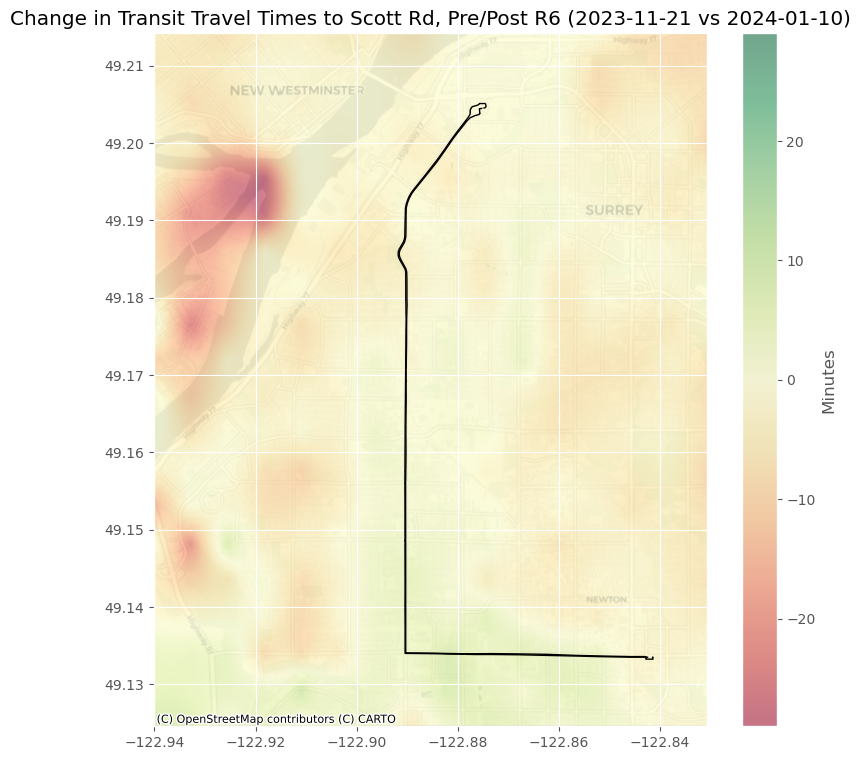

In [199]:
travel_times = origins.copy()

travel_times['transit_pre'] = transit_travel_times_pre.travel_time
travel_times['transit_post'] = transit_travel_times_post.travel_time

travel_times['delta'] = travel_times['transit_pre'] - travel_times['transit_post']

#positive number indicates a reduction in travel time

#delete NaN values
#travel_times = travel_times.dropna()

scatter_plot(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times['transit_pre'])
travel_times

from common_functions import plot_interpolated_grid

plt = plot_interpolated_grid(
    travel_times.geometry.x,
    travel_times.geometry.y,
    travel_times.delta,
    land = land,
    grid_size=400,
    cmap='RdYlGn',
    title = "Change in Transit Travel Times to Scott Rd, Pre/Post R6 ({} vs {})".format(travel_date_pre, travel_date_post)
)

#add r6 route to plot
r6_segments.plot(ax=plt.gca(), color='black', linewidth=1, label='R6 Route')

plt.show()